# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [1]:
import torch # 如果pytorch安装成功即可导入
print(torch.cuda.is_available()) # 查看CUDA是否可用
print(torch.cuda.device_count()) # 查看可用的CUDA数量
print(torch.version.cuda) # 查看CUDA的版本号
print(torch.__version__)# 查看PyTorch的版本号

True
1
10.2
1.10.0+cu102


In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# 查看PyTorch版本和设备
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu102  Device: cuda


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [3]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True,  # 训练集
                               download=True,  # 如果数据不存在则下载
                               transform=transforms.ToTensor())  # 转换为张量

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,  # 每个批次的大小
                                           shuffle=True)  # 是否打乱数据

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [4]:
for (X_train, y_train) in train_loader:
    # 四维张量：(批大小, 通道, 高, 宽)
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

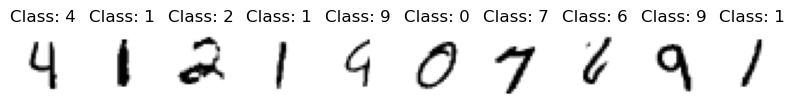

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    # 将第i个图像转换为28x28的张量
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    # 只需要实现forward函数，backward函数PyTorch会自动实现
    def forward(self, x):
        # Flatten the data (n, 1, 28, 28) => (n, 784)
        x = x.view(-1, 28*28)   # [32, 28*28]
        # hidden layer
        x = F.relu(self.fc1(x)) 
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)  # 输出层使用log_softmax激活函数

model = Net().to(device)  # 将模型加载到GPU上(如果可用)
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.5)  # 使用随机梯度下降优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [7]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):  # 从训练集中获取数据(图像和标签)
        # Copy data to GPU if needed
        data = data.to(device)  # x
        target = target.to(device)  # y

        # Zero gradient buffers
        optimizer.zero_grad()  # 梯度清零
        
        # Pass data through the network
        output = model(data)  # 前向传播

        # Calculate loss
        loss = criterion(output, target)  # 计算损失

        # Backpropagate
        loss.backward()  # 反向传播
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:  # 每200个批次打印一次
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [8]:
def validate(loss_vector, accuracy_vector):
    model.eval()  # 设置模型为评估模式
    val_loss, correct = 0, 0
    for data, target in validation_loader:  # 从验证集中获取数据
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()  # sum up batch loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()  # 对预测正确的数量进行累加

    val_loss /= len(validation_loader)  # 计算平均损失
    loss_vector.append(val_loss)  # 将损失添加到列表中

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [16]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303638
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.716246
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.319165
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.357666
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.400264
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.339860
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.227310
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.206419
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193258
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.427125

Validation set: Average loss: 0.1930, Accuracy: 9448/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.228876
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.059535
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.646278
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.162346
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.048544
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.063051
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.162360
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.411765
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.35

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

Text(0.5, 1.0, 'validation accuracy')

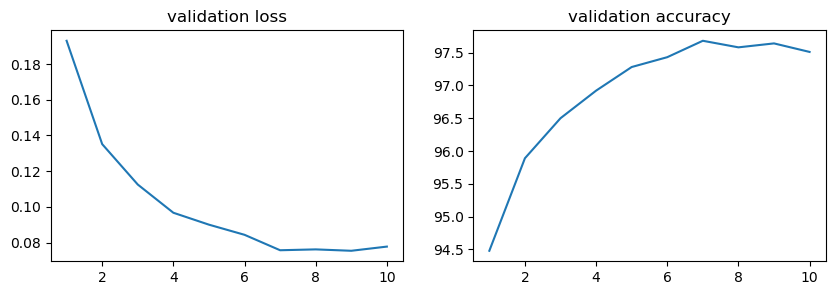

In [17]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.

In [22]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(64, 10)

    # 只需要实现forward函数，backward函数PyTorch会自动实现
    def forward(self, x):
        # Flatten the data (n, 1, 28, 28) => (n, 784)
        x = x.view(-1, 28*28)   # [32, 28*28]
        # hidden layer
        x = F.relu(self.fc1(x)) 
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.relu(self.fc3(x))
        x = self.fc3_drop(x)
        return F.log_softmax(self.fc4(x), dim=1)
        

my_model = MyNet().to(device)  # 将模型加载到GPU上(如果可用)
my_optimizer = torch.optim.SGD(my_model.parameters(), lr=0.02, momentum=0.6)
my_criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

print(my_model)

MyNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
def my_train(epoch,  model, optimizer, criterion, train_loader, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):  # 从训练集中获取数据(图像和标签)
        # Copy data to GPU if needed
        data = data.to(device)  # x
        target = target.to(device)  # y

        # Zero gradient buffers
        optimizer.zero_grad()  # 梯度清零
        
        # Pass data through the network
        output = model(data)  # 前向传播

        # Calculate loss
        loss = criterion(output, target)  # 计算损失

        # Backpropagate
        loss.backward()  # 反向传播
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:  # 每200个批次打印一次
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def my_validate(loss_vector, accuracy_vector, model, criterion, validation_loader):
    model.eval()  # 设置模型为评估模式
    val_loss, correct = 0, 0
    for data, target in validation_loader:  # 从验证集中获取数据
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()  # sum up batch loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()  # 对预测正确的数量进行累加

    val_loss /= len(validation_loader)  # 计算平均损失
    loss_vector.append(val_loss)  # 将损失添加到列表中

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [23]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    my_train(epoch, my_model, my_optimizer, my_criterion, train_loader, 400)
    my_validate(lossv, accv, my_model, my_criterion, validation_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313555
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.654761
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.726862
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.488321
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.561770

Validation set: Average loss: 0.2137, Accuracy: 9338/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.172674
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.258872
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.279590
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.266836
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.081521

Validation set: Average loss: 0.1281, Accuracy: 9576/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.093779
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.068448
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.155235
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.171465
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.153327

Validation set: Average loss: 0.1057, Accuracy: 9684/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.109427
Train Epoch: 4 [128

Text(0.5, 1.0, 'validation accuracy')

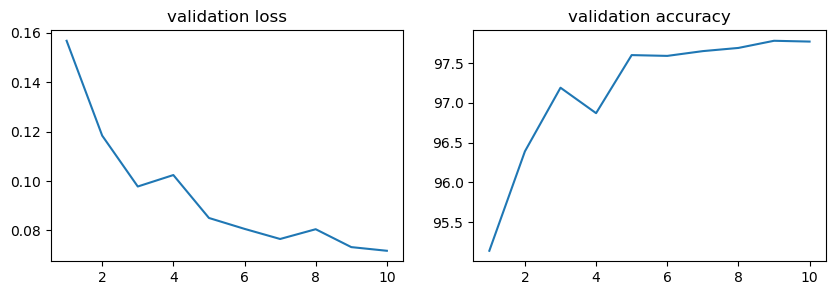

In [10]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

200


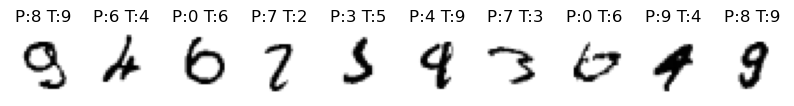

In [33]:
# 看下在validation set错误的图像
my_model.eval()
wrong_images = []
wrong_label = []
correct_label = []
for data, target in validation_loader:
    data = data.to(device)
    target = target.to(device)
    output = my_model(data)
    # 获取模型的预测
    _, predicted = torch.max(output.data, 1)
    
    # 找出错误的预测
    wrong_preds = (predicted != target)
    
    # 获取错误预测的索引
    wrong_indices = torch.where(wrong_preds)[0]
    
    # 保存错误的预测和对应的图像
    for i in wrong_indices:
        wrong_images.append(data[i])
        wrong_label.append(predicted[i])
        correct_label.append(target[i])

print(len(wrong_images))
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(wrong_images[i].cpu().numpy().reshape(28,28), cmap="gray_r")
    plt.title('P:'+str(wrong_label[i].item())+' T:'+str(correct_label[i].item()))


## MLP_Mixer

In [8]:
from mlp_mixer import MLPMixer

mix_model = MLPMixer(in_channels=1, image_size=28, patch_size=4, num_classes=10,
                        dim=64, depth=4, token_dim=64, channel_dim=128, dropout=0.2).to(device)
my_optimizer = torch.optim.SGD(mix_model.parameters(), lr=0.03, momentum=0.6)
my_criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

In [ ]:
print(mix_model)

In [9]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    my_train(epoch, mix_model, my_optimizer, my_criterion, train_loader, 400)
    my_validate(lossv, accv, mix_model, my_criterion, validation_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.256877
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.654261
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.341455
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.297226
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.468973

Validation set: Average loss: 0.1567, Accuracy: 9514/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.350879
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.183276
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.193616
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.248457
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.138643

Validation set: Average loss: 0.1184, Accuracy: 9639/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.195972
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.232455
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.372331
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.088693
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.032481

Validation set: Average loss: 0.0978, Accuracy: 9719/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.047593
Train Epoch: 4 [128